In [14]:
!git clone https://github.com/ankanbhunia/Handwriting-Transformers
%cd Handwriting-Transformers
!pip install --upgrade --no-cache-dir gdown
!gdown --id 16g9zgysQnWk7-353_tMig92KsZsrcM6k && unzip files.zip && rm files.zip

Cloning into 'Handwriting-Transformers'...
fatal: unable to access 'https://github.com/ankanbhunia/Handwriting-Transformers/': SSL: certificate subject name (*.iitk.ac.in) does not match target host name 'github.com'
[Errno 2] No such file or directory: 'Handwriting-Transformers'
/home/shubhamkn22/gpu_work/Handwriting_Transformers


/home/shubhamkn22/.conda/envs/cnn_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gdown]
/home/shubhamkn22/.conda/envs/cnn_env/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16g9zgysQnWk7-353_tMig92KsZsrcM6k
From (redirected): https://drive.google.com/uc?id=16g9zgysQnWk7-353_tMig92KsZsrcM6k&confirm=t&uuid=4a5377ab-0b6c-4257-be76-a1b9dc3072ad
To: /home/shubhamkn22/gpu_work/Handwriting_Transformers/files.zip
100%|████████████████████████████████████████| 685M/685M [00:20<00:00, 33.0MB/s]
Archive:  files.zip
replace files/cvl_model.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [31]:
import os
import time
from data.dataset import TextDataset, TextDatasetval
import torch
import cv2
import os
import numpy as np
from models.model import TRGAN
from params import *
from torch import nn
from data.dataset import get_transform
import pickle
from PIL import Image
import tqdm
import shutil

In [32]:
text = "Welcome to CS787 Generative AI course. This is a sample text to test the Handwriting Transformer model. This model is a GAN based model that has 4 components Generator, Discriminator, Recognizer, Writer identifier."
output_path = 'results'

In [33]:
model_path = 'saved_models/IAM-339-15-E3D3-LR0.00005-bs8/model100.pth'; data_path = 'files/IAM-32.pickle' #(iam)
#model_path = 'files/cvl_model.pth'; data_path = 'files/CVL-32.pickle' #(cvl)
#model_path = 'files/iam_model.pth'; data_path = 'files/CVL-32.pickle' #(iam-cvl-cross)
#model_path = 'files/cvl_model.pth'; data_path = 'files/IAM-32.pickle' #(cvl-iam-cross)#

In [34]:
print ('(1) Loading dataset files...')

TextDatasetObjval = TextDatasetval(base_path = data_path, num_examples = 15)
datasetval = torch.utils.data.DataLoader(
            TextDatasetObjval,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True, drop_last=True,
            collate_fn=TextDatasetObjval.collate_fn)

print ('(2) Loading model...')

model = TRGAN()
model.load_state_dict(torch.load(model_path))
print (model_path+' : Model loaded Successfully')

print ('(3) Loading text content...')
text_encode =  [j.encode() for j in text.split(' ')]
eval_text_encode, eval_len_text = model.netconverter.encode(text_encode)
eval_text_encode = eval_text_encode.to('cuda:0').repeat(batch_size, 1, 1)


(1) Loading dataset files...
(2) Loading model...
initialize network with N02
initialize network with N02
initialize network with N02
saved_models/IAM-339-15-E3D3-LR0.00005-bs8/model100.pth : Model loaded Successfully
(3) Loading text content...


In [35]:

if os.path.isdir(output_path): shutil.rmtree(output_path)
os.makedirs(output_path, exist_ok = True)

for i,data_val in enumerate(tqdm.tqdm(datasetval)): 

    page_val = model._generate_page(data_val['simg'].to(DEVICE), data_val['swids'], eval_text_encode,eval_len_text)

    cv2.imwrite(output_path+'/image' + str(i) + '.png', page_val*255)

print ('\nOutput images saved in : ' + output_path)

100%|████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Output images saved in : results


Loading and padding generated images: 100%|█| 20/20 [00:00<00:00,
Loading reference images: 100%|█| 161/161 [00:01<00:00, 114.71it/


SSIM (Geometric Score proxy): 0.8446
MSE (FID proxy): 0.011253


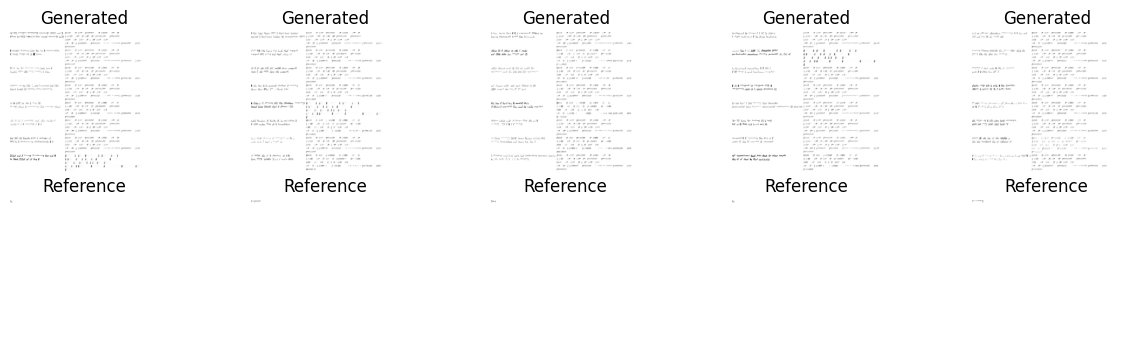

In [36]:
# -----------------------------
# Jupyter cell: Evaluate generated images (with padding)
# -----------------------------
import os
import cv2
import torch
import numpy as np
from torch.nn import functional as F
from pytorch_msssim import ssim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_path = 'results'

# Load generated images and determine max size
generated_files = sorted([f for f in os.listdir(output_path) if f.endswith('.png')])
max_h, max_w = 0, 0
for f in generated_files:
    img = cv2.imread(os.path.join(output_path, f), cv2.IMREAD_GRAYSCALE)
    max_h = max(max_h, img.shape[0])
    max_w = max(max_w, img.shape[1])

# Pad generated images
generated_images = []
for f in tqdm(generated_files, desc="Loading and padding generated images"):
    img = cv2.imread(os.path.join(output_path, f), cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    pad_h = max_h - h
    pad_w = max_w - w
    img = np.pad(img, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=255)  # white padding
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    generated_images.append(img_tensor)

generated_images = torch.cat(generated_images, dim=0).to(device)

# Load reference images (style images) and pad to same size
# Load reference images (style images) and pad to same size
from data.dataset import TextDatasetval
TextDatasetObjval = TextDatasetval(base_path='files/IAM-32.pickle', num_examples=len(generated_images))
datasetval = torch.utils.data.DataLoader(
    TextDatasetObjval,
    batch_size=1,
    shuffle=False,
    collate_fn=TextDatasetObjval.collate_fn
)

real_images = []
for data_val in tqdm(datasetval, desc="Loading reference images"):
    simg = ((data_val['simg'] + 1)/2).clamp(0,1)  # normalize to [0,1]
    simg = simg.squeeze().cpu()  # remove batch dim
    
    # Ensure shape is [H,W]
    if simg.ndim == 3:  # [C,H,W]
        simg = simg[0]   # take first channel (grayscale)

    h, w = simg.shape
    pad_h = max_h - h
    pad_w = max_w - w
    simg = np.pad(simg.numpy(), ((0,pad_h),(0,pad_w)), mode='constant', constant_values=1.0)  # white padding
    simg_tensor = torch.tensor(simg).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    real_images.append(simg_tensor)

real_images = torch.cat(real_images[:len(generated_images)], dim=0).to(device)


# Compute SSIM and MSE
ssim_value = ssim(generated_images, real_images, data_range=1.0)
mse_value = F.mse_loss(generated_images, real_images)

print(f"SSIM (Geometric Score proxy): {ssim_value.item():.4f}")
print(f"MSE (FID proxy): {mse_value.item():.6f}")

# Display a few sample images
num_display = min(5, len(generated_images))
plt.figure(figsize=(15,4))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow(generated_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Generated")
    plt.axis('off')

    plt.subplot(2, num_display, i+1+num_display)
    plt.imshow(real_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Reference")
    plt.axis('off')

plt.show()


Loading generated images: 100%|██| 20/20 [00:00<00:00, 38.47it/s]
Loading reference images: 100%|█| 161/161 [00:01<00:00, 113.74it/


FID-like score using Inception features: 410973315404422851854336.0000


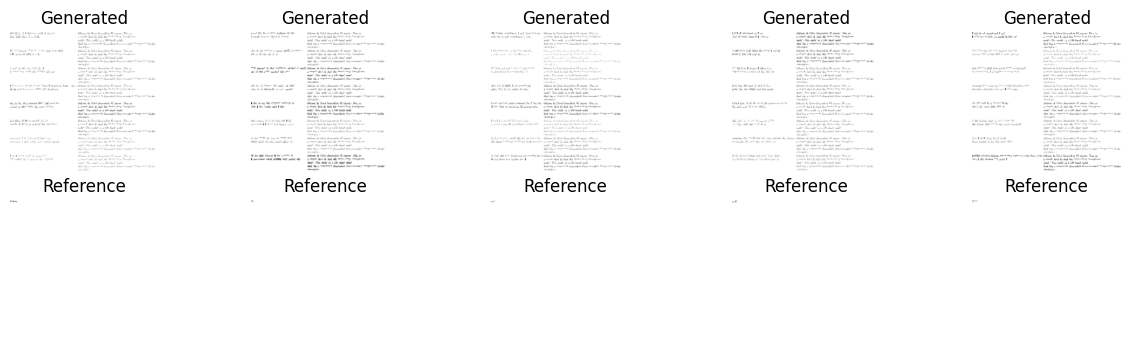

In [26]:
# -----------------------------
# Evaluate generated images using Inception features (FID-like score)
# -----------------------------
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from models.inception import InceptionV3, calculate_frechet_distance

device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_path = 'results'

# -----------------------------
# 1️⃣ Load generated images and pad
# -----------------------------
generated_files = sorted([f for f in os.listdir(output_path) if f.endswith('.png')])
max_h, max_w = 0, 0
for f in generated_files:
    img = cv2.imread(os.path.join(output_path, f), cv2.IMREAD_GRAYSCALE)
    max_h = max(max_h, img.shape[0])
    max_w = max(max_w, img.shape[1])

generated_images = []
for f in tqdm(generated_files, desc="Loading generated images"):
    img = cv2.imread(os.path.join(output_path, f), cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    pad_h = max_h - h
    pad_w = max_w - w
    img = np.pad(img, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=255)
    img = img.astype(np.float32)/255.0
    img = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    generated_images.append(img)

generated_images = torch.cat(generated_images, dim=0).to(device)

# -----------------------------
# 2️⃣ Load reference images from dataset
# -----------------------------
from data.dataset import TextDatasetval
TextDatasetObjval = TextDatasetval(base_path='files/IAM-32.pickle', num_examples=len(generated_images))
datasetval = torch.utils.data.DataLoader(
    TextDatasetObjval,
    batch_size=1,
    shuffle=False,
    collate_fn=TextDatasetObjval.collate_fn
)

real_images = []
for data_val in tqdm(datasetval, desc="Loading reference images"):
    simg = ((data_val['simg'] + 1)/2).clamp(0,1)  # normalize [0,1]
    simg = simg.squeeze().cpu()
    if simg.ndim == 3:
        simg = simg[0]
    h, w = simg.shape
    pad_h = max_h - h
    pad_w = max_w - w
    simg = np.pad(simg.numpy(), ((0,pad_h),(0,pad_w)), mode='constant', constant_values=1.0)
    simg_tensor = torch.tensor(simg).unsqueeze(0).unsqueeze(0)
    real_images.append(simg_tensor)

real_images = torch.cat(real_images[:len(generated_images)], dim=0).to(device)

# -----------------------------
# 3️⃣ Compute Inception features
# -----------------------------
inception_model = InceptionV3(output_blocks=[3]).to(device).eval()  # final avgpool features

with torch.no_grad():
    # Convert grayscale to 3-channel by repeating
    gen_feats = inception_model(generated_images.repeat(1,3,1,1))[0].squeeze(-1).squeeze(-1)  # [N,2048]
    real_feats = inception_model(real_images.repeat(1,3,1,1))[0].squeeze(-1).squeeze(-1)       # [N,2048]

gen_feats = gen_feats.cpu().numpy()
real_feats = real_feats.cpu().numpy()

# -----------------------------
# 4️⃣ Compute mean and covariance
# -----------------------------
mu_gen = np.mean(gen_feats, axis=0)
sigma_gen = np.cov(gen_feats, rowvar=False)
mu_real = np.mean(real_feats, axis=0)
sigma_real = np.cov(real_feats, rowvar=False)

# -----------------------------
# 5️⃣ Calculate FID
# -----------------------------
fid_score = calculate_frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)
print(f"FID-like score using Inception features: {fid_score:.4f}")

# -----------------------------
# 6️⃣ Optional: Display some examples
# -----------------------------
num_display = min(5, len(generated_images))
plt.figure(figsize=(15,4))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow(generated_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Generated")
    plt.axis('off')

    plt.subplot(2, num_display, i+1+num_display)
    plt.imshow(real_images[i].squeeze().cpu(), cmap='gray')
    plt.title("Reference")
    plt.axis('off')
plt.show()


In [30]:
import torch
import numpy as np
import cv2
from models.inception import InceptionV3, calculate_frechet_distance

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Load images
# -----------------------------
ref_path = 'custom_data_1/style_examples/test.jpg'
gen_path = 'output.png'

ref_img = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
gen_img = cv2.imread(gen_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0

# Pad images to same size
max_h = max(ref_img.shape[0], gen_img.shape[0])
max_w = max(ref_img.shape[1], gen_img.shape[1])

def pad_image(img, max_h, max_w):
    h, w = img.shape
    pad_h = max_h - h
    pad_w = max_w - w
    img = np.pad(img, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=1.0)  # white padding
    return img

ref_img = pad_image(ref_img, max_h, max_w)
gen_img = pad_image(gen_img, max_h, max_w)

# Convert to tensors [1,3,H,W] for Inception
ref_tensor = torch.tensor(ref_img).unsqueeze(0).repeat(1,3,1,1).to(device)
gen_tensor = torch.tensor(gen_img).unsqueeze(0).repeat(1,3,1,1).to(device)

# -----------------------------
# Extract Inception features
# -----------------------------
# Extract features
inception = InceptionV3(output_blocks=[3]).to(device).eval()

# Reference image tensor: [1,1,H,W] -> repeat 3 channels
ref_tensor = ref_tensor.repeat(1,3,1,1).to(device)  
gen_tensor = gen_tensor.repeat(1,3,1,1).to(device)

with torch.no_grad():
    ref_feat = inception(ref_tensor)[0].view(1,-1).cpu().numpy()
    gen_feat = inception(gen_tensor)[0].view(1,-1).cpu().numpy()

# L2 distance proxy
fid_proxy = np.linalg.norm(ref_feat - gen_feat)
print("FID proxy (L2 distance on Inception features):", fid_proxy)


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 9, 299, 299] to have 3 channels, but got 9 channels instead